In [1]:
import matplotlib
import matplotlib.pyplot as plt
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np
from scipy.optimize import minimize
from collections import defaultdict
from typing import Sequence
 
 
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import QAOAAnsatz
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
 
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime.fake_provider import FakeWashingtonV2

from qiskit import QuantumCircuit

from qiskit.circuit.library import efficient_su2
from qiskit.circuit.library import TwoLocal
from qiskit.circuit.library import RealAmplitudes

In [2]:
import numpy as np
import qubovert

In [7]:
data = np.load("sat.npz")
qubo_mat = data['qubo']
n_qubits = len(data['syms'])
print(data)
print(data['syms'])
print(qubo_mat)

NpzFile 'sat.npz' with keys: qubo, lvars, syms
['sat.$id00006.A' 'sat.$id00006.B' 'sat.$id00006.Y' 'sat.$id00004.A'
 'sat.$id00004.Y' 'sat.$id00005.A' 'sat.$id00005.B' 'sat.$id00005.Y'
 'sat.b' 'sat.c' 'sat.a']
[[ 4.  2. -4.  0.  0.  0.  0.  0.  0.  0. -8.]
 [ 0.  4. -4.  0. -8.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  2.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  2.  4.  0.  0. -8.  0.  0.  0.]
 [ 0.  0.  0.  0.  2.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  6.  2. -4. -8.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  6. -4.  0. -8.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  6.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  4.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  4.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  4.]]


In [12]:
qubo = qubovert.utils.matrix_to_qubo(qubo_mat)
ising = qubovert.utils.qubo_to_quso(qubo)
qubo_dict = dict(qubo)
ising_dict = dict(ising)
print(ising_dict)
ising_dict.popitem()
print(ising_dict)
ising_dict.pop(())
ising_mat = qubovert.utils.qubo_to_matrix(ising_dict)
print(ising_mat)

{(0,): np.float64(0.5), (): np.float64(10.0), (0, 1): np.float64(0.5), (1,): np.float64(0.5), (0, 2): np.float64(-1.0), (2,): np.float64(1.0), (0, 10): np.float64(-2.0), (1, 2): np.float64(-1.0), (1, 4): np.float64(-2.0), (3, 4): np.float64(1.0), (3, 7): np.float64(-2.0), (7,): np.float64(1.0), (5,): np.float64(-0.5), (5, 6): np.float64(0.5), (6,): np.float64(-0.5), (5, 7): np.float64(-1.0), (5, 8): np.float64(-2.0), (6, 7): np.float64(-1.0), (6, 9): np.float64(-2.0)}
{(0,): np.float64(0.5), (): np.float64(10.0), (0, 1): np.float64(0.5), (1,): np.float64(0.5), (0, 2): np.float64(-1.0), (2,): np.float64(1.0), (0, 10): np.float64(-2.0), (1, 2): np.float64(-1.0), (1, 4): np.float64(-2.0), (3, 4): np.float64(1.0), (3, 7): np.float64(-2.0), (7,): np.float64(1.0), (5,): np.float64(-0.5), (5, 6): np.float64(0.5), (6,): np.float64(-0.5), (5, 7): np.float64(-1.0), (5, 8): np.float64(-2.0), (6, 7): np.float64(-1.0)}
[[ 0.5  0.5 -1.   0.   0.   0.   0.   0.   0.   0.  -2. ]
 [ 0.   0.5 -1.   0.  

In [13]:
def build_paulis(matrix):
    pauli_list = []
    for i in range(len(matrix)):
        pauli_list.append(("Z", [i], matrix[i][i]))
        for j in range(i+1, len(matrix)):
            pauli_list.append(("ZZ", [i, j], matrix[i][j]))
    return pauli_list
 
 
sat_paulis = build_paulis(ising_mat)
print(sat_paulis)
cost_hamiltonian = SparsePauliOp.from_sparse_list(sat_paulis, n_qubits)
print("Cost Function Hamiltonian:", cost_hamiltonian)

[('Z', [0], np.float64(0.5)), ('ZZ', [0, 1], np.float64(0.5)), ('ZZ', [0, 2], np.float64(-1.0)), ('ZZ', [0, 3], np.float64(0.0)), ('ZZ', [0, 4], np.float64(0.0)), ('ZZ', [0, 5], np.float64(0.0)), ('ZZ', [0, 6], np.float64(0.0)), ('ZZ', [0, 7], np.float64(0.0)), ('ZZ', [0, 8], np.float64(0.0)), ('ZZ', [0, 9], np.float64(0.0)), ('ZZ', [0, 10], np.float64(-2.0)), ('Z', [1], np.float64(0.5)), ('ZZ', [1, 2], np.float64(-1.0)), ('ZZ', [1, 3], np.float64(0.0)), ('ZZ', [1, 4], np.float64(-2.0)), ('ZZ', [1, 5], np.float64(0.0)), ('ZZ', [1, 6], np.float64(0.0)), ('ZZ', [1, 7], np.float64(0.0)), ('ZZ', [1, 8], np.float64(0.0)), ('ZZ', [1, 9], np.float64(0.0)), ('ZZ', [1, 10], np.float64(0.0)), ('Z', [2], np.float64(1.0)), ('ZZ', [2, 3], np.float64(0.0)), ('ZZ', [2, 4], np.float64(0.0)), ('ZZ', [2, 5], np.float64(0.0)), ('ZZ', [2, 6], np.float64(0.0)), ('ZZ', [2, 7], np.float64(0.0)), ('ZZ', [2, 8], np.float64(0.0)), ('ZZ', [2, 9], np.float64(0.0)), ('ZZ', [2, 10], np.float64(0.0)), ('Z', [3], np.

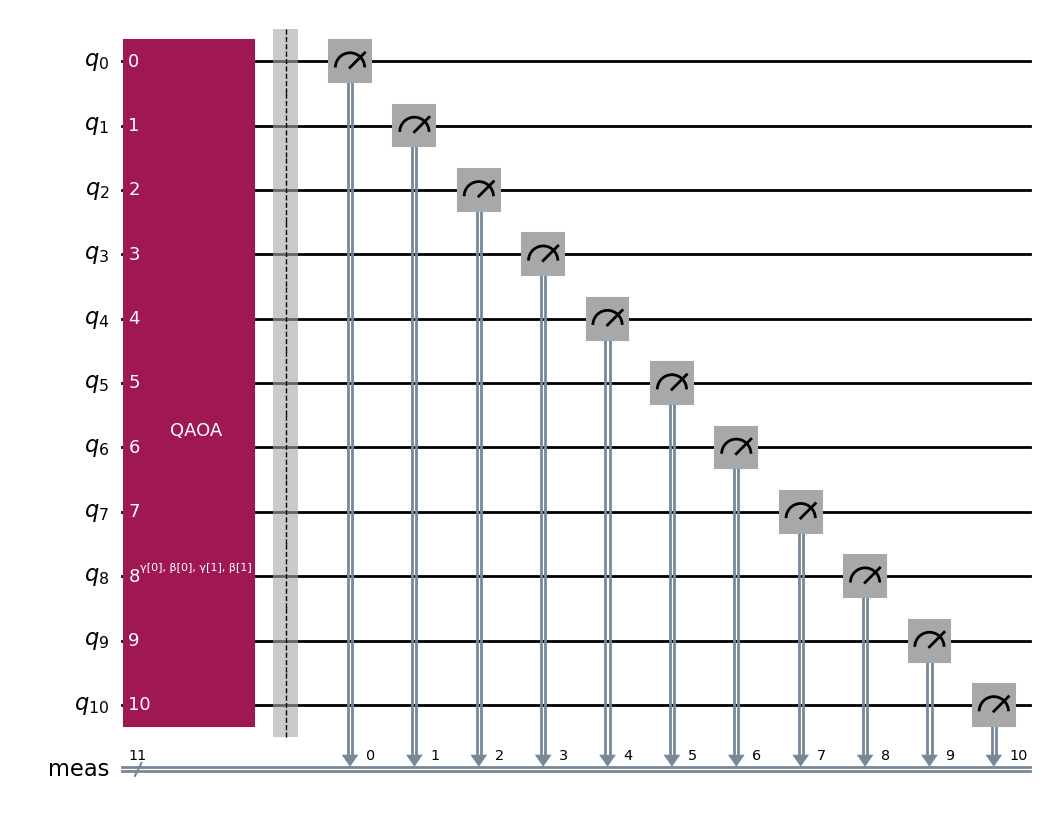

In [14]:
ansatz = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=2)
ansatz.measure_all()
ansatz.draw("mpl")

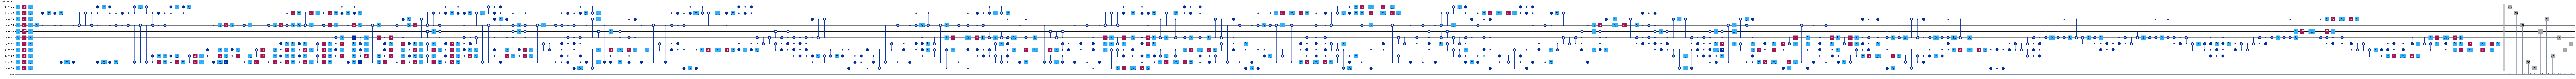

In [15]:
backend = FakeWashingtonV2()


 
# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
 
candidate_circuit = pm.run(ansatz)
candidate_circuit.draw("mpl", fold=False, idle_wires=False)

In [16]:
init_params = np.random.rand(ansatz.num_parameters) * 2 * np.pi

In [17]:
objective_func_vals = []  # Global variable

In [18]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator):
    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)
 
    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])
 
    results = job.result()[0]
    cost = results.data.evs
 
    objective_func_vals.append(cost)
 
    return cost

In [19]:

with Session(backend=backend) as session:
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 1000
 
    # Set simple error suppression/mitigation options
    #estimator.options.dynamical_decoupling.enable = True
    #estimator.options.dynamical_decoupling.sequence_type = "XY4"
    #estimator.options.twirling.enable_gates = True
    #estimator.options.twirling.num_randomizations = "auto"
 
    result = minimize(
        cost_func_estimator,
        init_params,
        args=(candidate_circuit, cost_hamiltonian, estimator),
        method="COBYLA",
        tol=1e-2,
    )
    print(result)

 message: Return from COBYLA because the trust region radius reaches its lower bound.
 success: True
  status: 0
     fun: -2.553446553446553
       x: [ 3.483e+00  1.629e+00  2.815e+00  2.231e+00]
    nfev: 24
   maxcv: 0.0


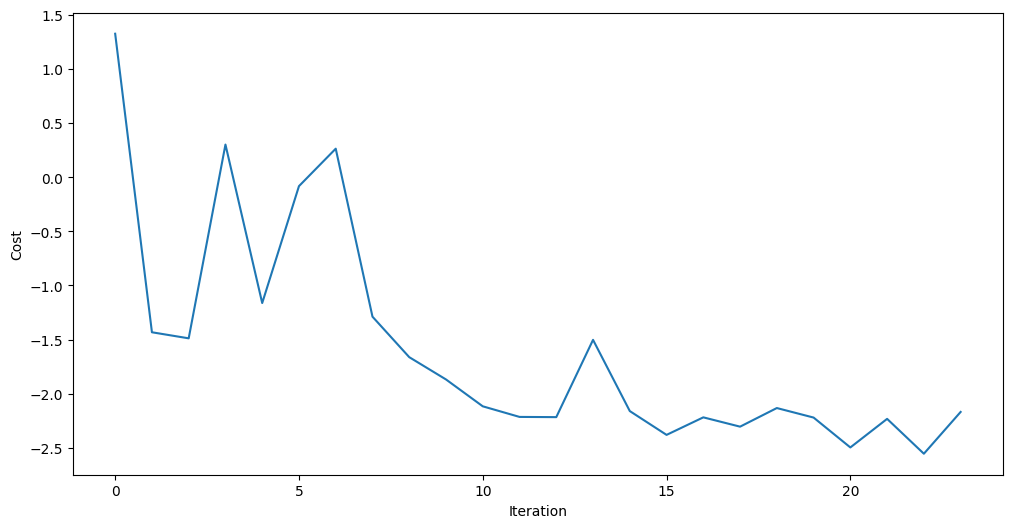

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

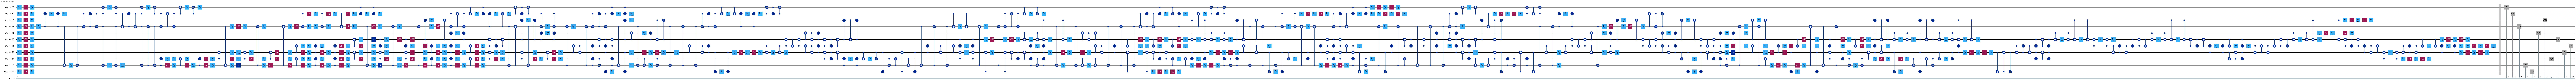

In [21]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw("mpl", fold=False, idle_wires=False)

In [22]:
# If using qiskit-ibm-runtime<0.24.0, change `mode=` to `backend=`
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10000
 
# Set simple error suppression/mitigation options
#sampler.options.dynamical_decoupling.enable = True
#sampler.options.dynamical_decoupling.sequence_type = "XY4"
#sampler.options.twirling.enable_gates = True
#sampler.options.twirling.num_randomizations = "auto"
 
pub = (optimized_circuit,)
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val / shots for key, val in counts_int.items()}
final_distribution_bin = {key: val / shots for key, val in counts_bin.items()}
print(final_distribution_int)

{1237: 0.0005, 136: 0.0005, 1851: 0.0014, 2025: 0.0032, 1791: 0.0025, 521: 0.0003, 661: 0.0001, 1281: 0.001, 1233: 0.0005, 905: 0.0001, 756: 0.0004, 2031: 0.003, 1755: 0.002, 1530: 0.0014, 1274: 0.0005, 1398: 0.0006, 1479: 0.0003, 801: 0.0006, 1622: 0.001, 1720: 0.0005, 18: 0.0011, 2023: 0.001, 794: 0.0003, 507: 0.0013, 548: 0.0003, 1721: 0.0005, 1055: 0.0007, 2009: 0.0007, 1555: 0.0006, 744: 0.0011, 1215: 0.001, 954: 0.0013, 1293: 0.0003, 1361: 0.0009, 164: 0.0001, 823: 0.0012, 1258: 0.0009, 1060: 0.0001, 1260: 0.0007, 1902: 0.0008, 1727: 0.0014, 1325: 0.0007, 1989: 0.0012, 672: 0.0005, 1735: 0.0005, 1789: 0.0016, 566: 0.0005, 1769: 0.0012, 2038: 0.0014, 173: 0.0007, 549: 0.0004, 168: 0.0004, 10: 0.0004, 1579: 0.0007, 605: 0.0004, 2027: 0.0025, 1385: 0.0008, 621: 0.0004, 61: 0.0004, 370: 0.0011, 1299: 0.0008, 722: 0.0008, 1252: 0.0003, 246: 0.0006, 456: 0.0006, 1562: 0.0007, 1759: 0.0032, 1402: 0.0005, 1103: 0.0002, 1915: 0.001, 1921: 0.0006, 2037: 0.0011, 493: 0.0012, 266: 0.0003, 17

In [23]:
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]
 
 
keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, len(data['syms']))
most_likely_bitstring.reverse()
 
print("Result bitstring:", most_likely_bitstring)

Result bitstring: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


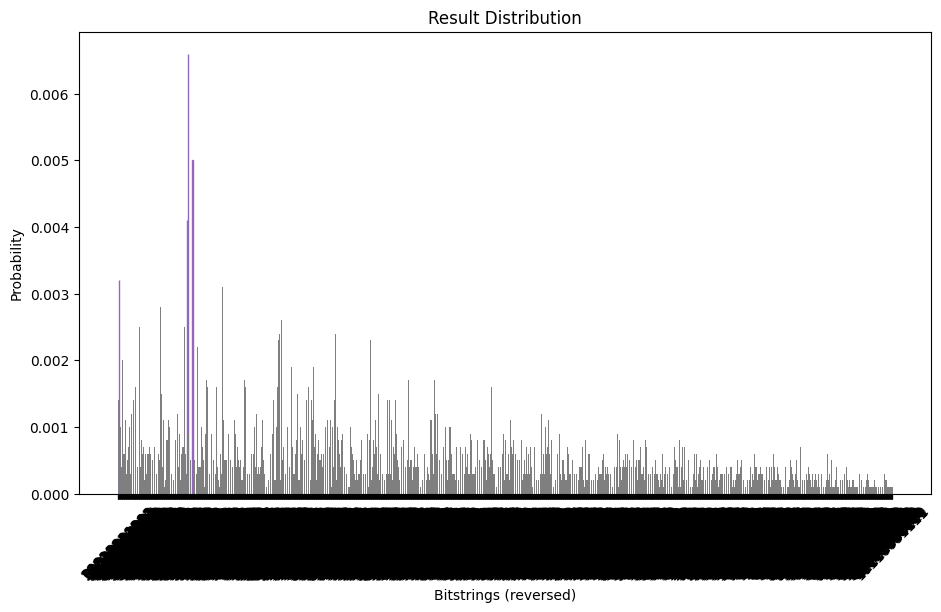

In [24]:
matplotlib.rcParams.update({"font.size": 10})
final_bits = final_distribution_bin
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]
positions = []
for value in top_4_values:
    positions.append(np.where(values == value)[0])
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
for p in positions:
    ax.get_children()[int(p[0])].set_color("tab:purple")
plt.show()

In [40]:
print(final_distribution_bin)
last_3 = {}
first_3 = {}
for (key, value) in final_distribution_bin.items():
    last = key[-3:]
    first = key[:3]
    if last in last_3.keys():
        last_3[last] += value
    else:
        last_3[last] = value
    if first in first_3.keys():
        first_3[first] += value
    else:
        first_3[first] = value

{'10011010101': 0.0005, '00010001000': 0.0005, '11100111011': 0.0014, '11111101001': 0.0032, '11011111111': 0.0025, '01000001001': 0.0003, '01010010101': 0.0001, '10100000001': 0.001, '10011010001': 0.0005, '01110001001': 0.0001, '01011110100': 0.0004, '11111101111': 0.003, '11011011011': 0.002, '10111111010': 0.0014, '10011111010': 0.0005, '10101110110': 0.0006, '10111000111': 0.0003, '01100100001': 0.0006, '11001010110': 0.001, '11010111000': 0.0005, '00000010010': 0.0011, '11111100111': 0.001, '01100011010': 0.0003, '00111111011': 0.0013, '01000100100': 0.0003, '11010111001': 0.0005, '10000011111': 0.0007, '11111011001': 0.0007, '11000010011': 0.0006, '01011101000': 0.0011, '10010111111': 0.001, '01110111010': 0.0013, '10100001101': 0.0003, '10101010001': 0.0009, '00010100100': 0.0001, '01100110111': 0.0012, '10011101010': 0.0009, '10000100100': 0.0001, '10011101100': 0.0007, '11101101110': 0.0008, '11010111111': 0.0014, '10100101101': 0.0007, '11111000101': 0.0012, '01010100000': 0

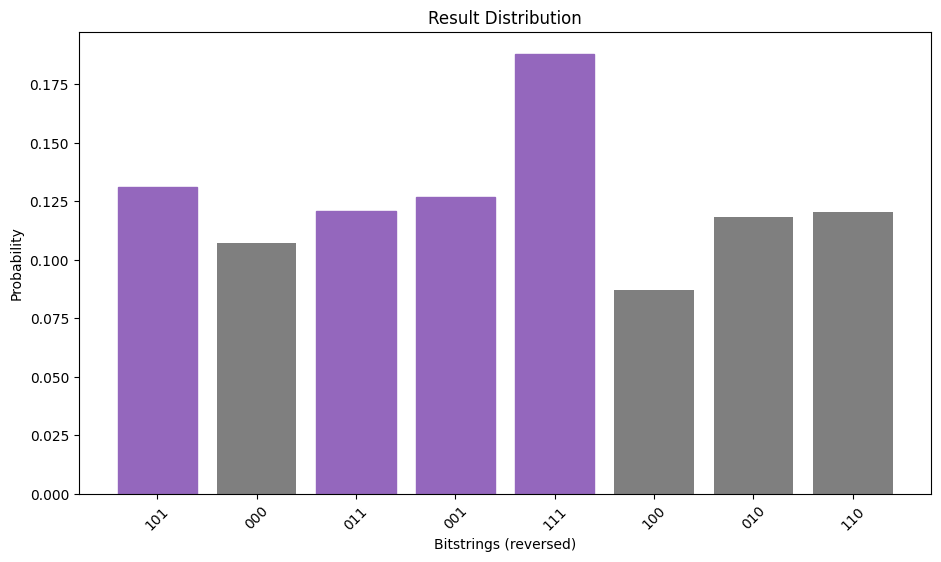

In [41]:
matplotlib.rcParams.update({"font.size": 10})
final_bits = last_3
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]
positions = []
for value in top_4_values:
    positions.append(np.where(values == value)[0])
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
for p in positions:
    ax.get_children()[int(p[0])].set_color("tab:purple")
plt.show()

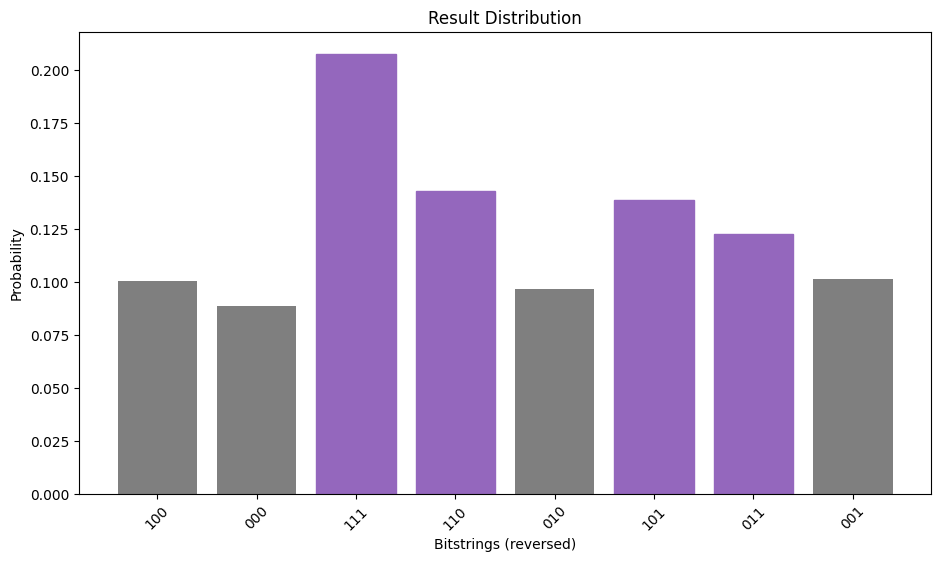

In [42]:
matplotlib.rcParams.update({"font.size": 10})
final_bits = first_3
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]
positions = []
for value in top_4_values:
    positions.append(np.where(values == value)[0])
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
for p in positions:
    ax.get_children()[int(p[0])].set_color("tab:purple")
plt.show()